In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys
import seaborn as sns

# Try to get the script directory; if in a notebook, use the current working directory
try:
    SCRIPT_DIR = Path(__file__).resolve().parent
except NameError:
    # We are in a notebook/interactive session
    SCRIPT_DIR = Path(os.getcwd()).resolve()

# Adjust this based on where your 'logs' folder is relative to the notebook
# If 'logs' is in the same folder as your notebook, use SCRIPT_DIR
# If 'logs' is one level up, use SCRIPT_DIR.parent
PROJECT_ROOT = SCRIPT_DIR.parent

LOG_FILE = PROJECT_ROOT / "logs" / "compare_k_log.csv"
PLOT_DIR = PROJECT_ROOT / "logs" / "plots"

print(f"Looking for log file at: {LOG_FILE}")

def load_data(LOG_FILE):
    if not os.path.exists(LOG_FILE):
        print(f"Error: Log file not found at {LOG_FILE}")
        sys.exit(1)

    try:
        df = pd.read_csv(LOG_FILE)
        # Clean column names (remove spaces)
        df.columns = df.columns.str.strip()
        return df
    except Exception as e:
        print(f"Error reading CSV: {e}")
        sys.exit(1)


Looking for log file at: /Users/nautilus/gridfw/logs/compare_k_log.csv


In [22]:
df = load_data(LOG_FILE)
df['Relative Error (%)'] = (1 - df['Ratio']) * 100

In [23]:
df.columns = df.columns.str.lower()
df

,timestamp,dataset,p,experiment,k,steps,samples,alpha,greedy_obj,fw_obj,ratio,greedy_time_s,fw_time_s,speedup_x,status,relative error (%)
0,2026-01-28 12:40:15,Residential,103,compare_k1_a0.1_m20,1,100,20,0.1,67.5649,67.0536,0.9924,0.0010,0.0177,0.0582,DONE,0.76
1,2026-01-28 12:40:15,Residential,103,compare_k10_a0.1_m20,10,200,20,0.1,94.3341,91.5609,0.9706,0.0108,0.0351,0.3091,DONE,2.94
2,2026-01-28 12:40:15,Residential,103,compare_k20_a0.1_m20,20,400,20,0.1,100.0077,99.6479,0.9964,0.0266,0.0726,0.3659,DONE,0.36
3,2026-01-28 12:40:15,Residential,103,compare_k30_a0.1_m20,30,600,20,0.1,101.9689,101.7951,0.9983,0.0498,0.1064,0.4684,DONE,0.17
4,2026-01-28 12:40:15,Residential,103,compare_k51_a0.1_m20,51,1020,20,0.1,102.9037,102.8715,0.9997,0.1095,0.1804,0.6068,DONE,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,2026-01-28 15:50:50,Myocardial,111,compare_k1_a0.2_m50_block_1,1,100,50,0.2,2.8590,2.8590,1.0000,0.0020,0.0391,0.0521,DONE,0.00
216,2026-01-28 15:50:50,Myocardial,111,compare_k11_a0.2_m50_block_1,11,220,50,0.2,21.5093,21.3965,0.9948,0.0135,0.0689,0.1961,DONE,0.52
217,2026-01-28 15:50:50,Myocardial,111,compare_k22_a0.2_m50_block_1,22,440,50,0.2,35.2432,34.7379,0.9857,0.0318,0.1375,0.2312,DONE,1.43
218,2026-01-28 15:50:50,Myocardial,111,compare_k33_a0.2_m50_block_1,33,660,50,0.2,46.9708,46.1631,0.9828,0.0599,0.2091,0.2864,DONE,1.72


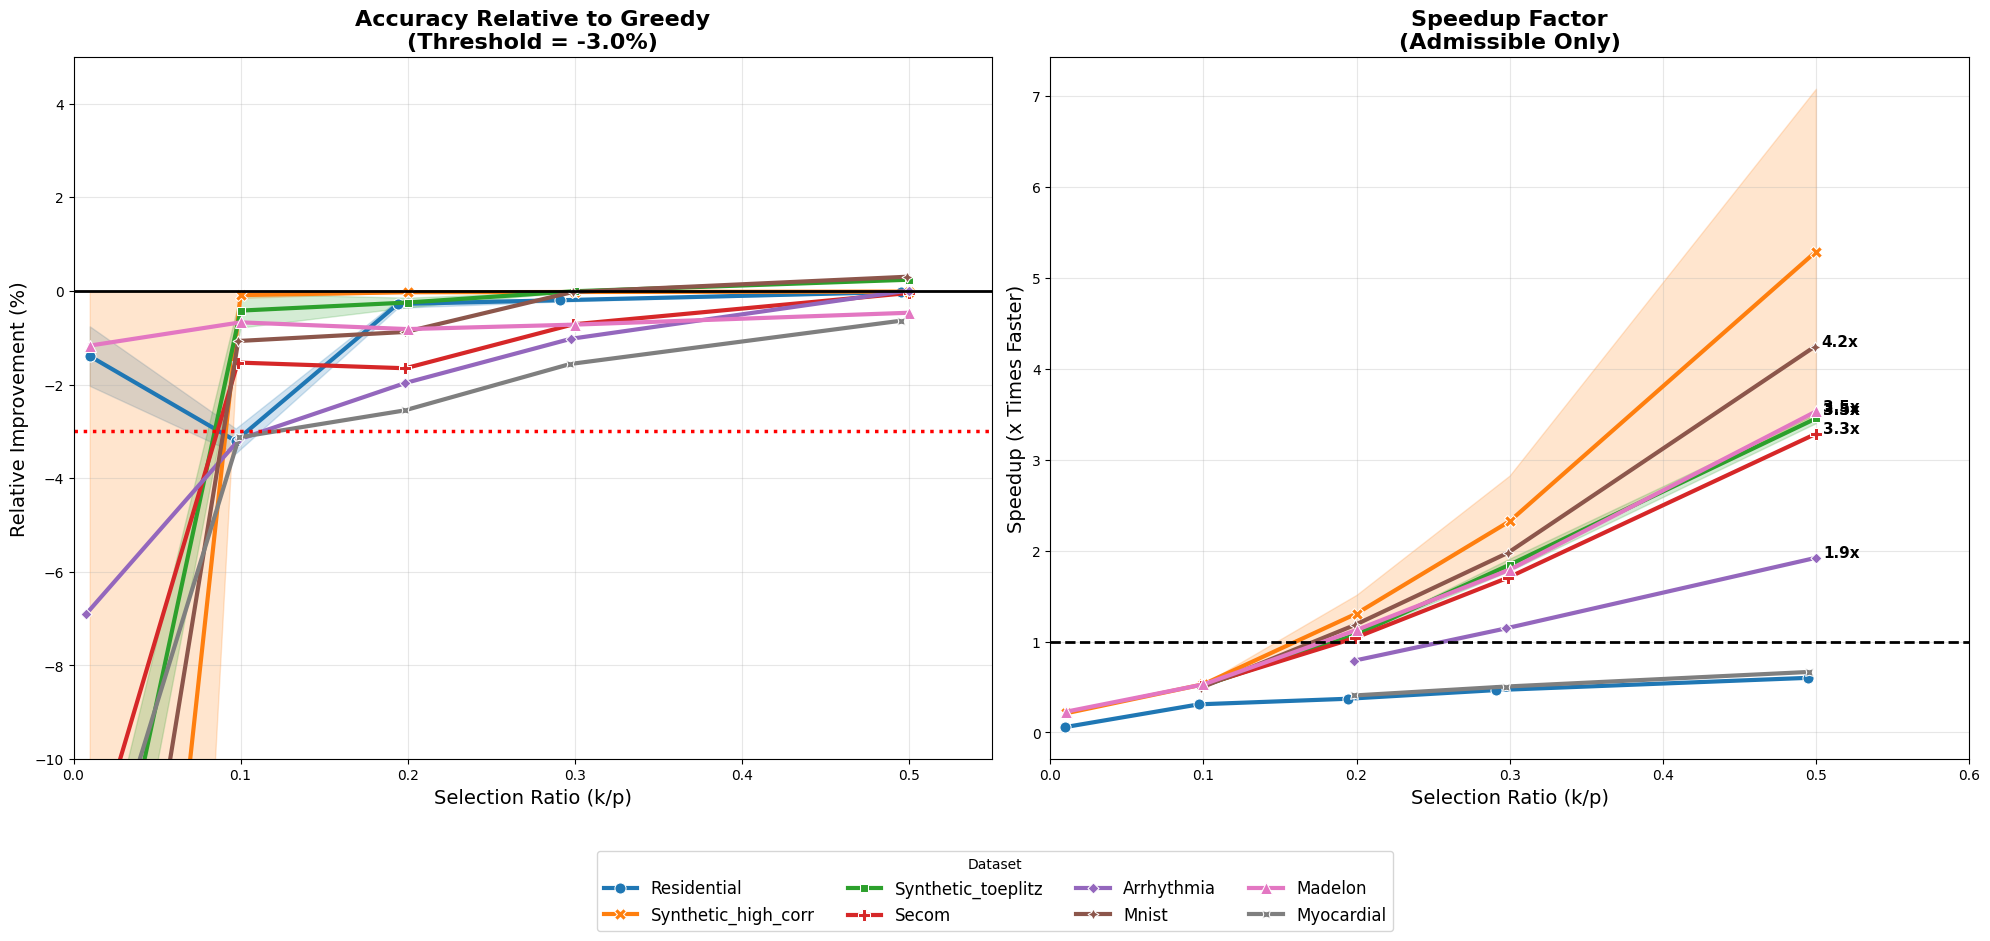

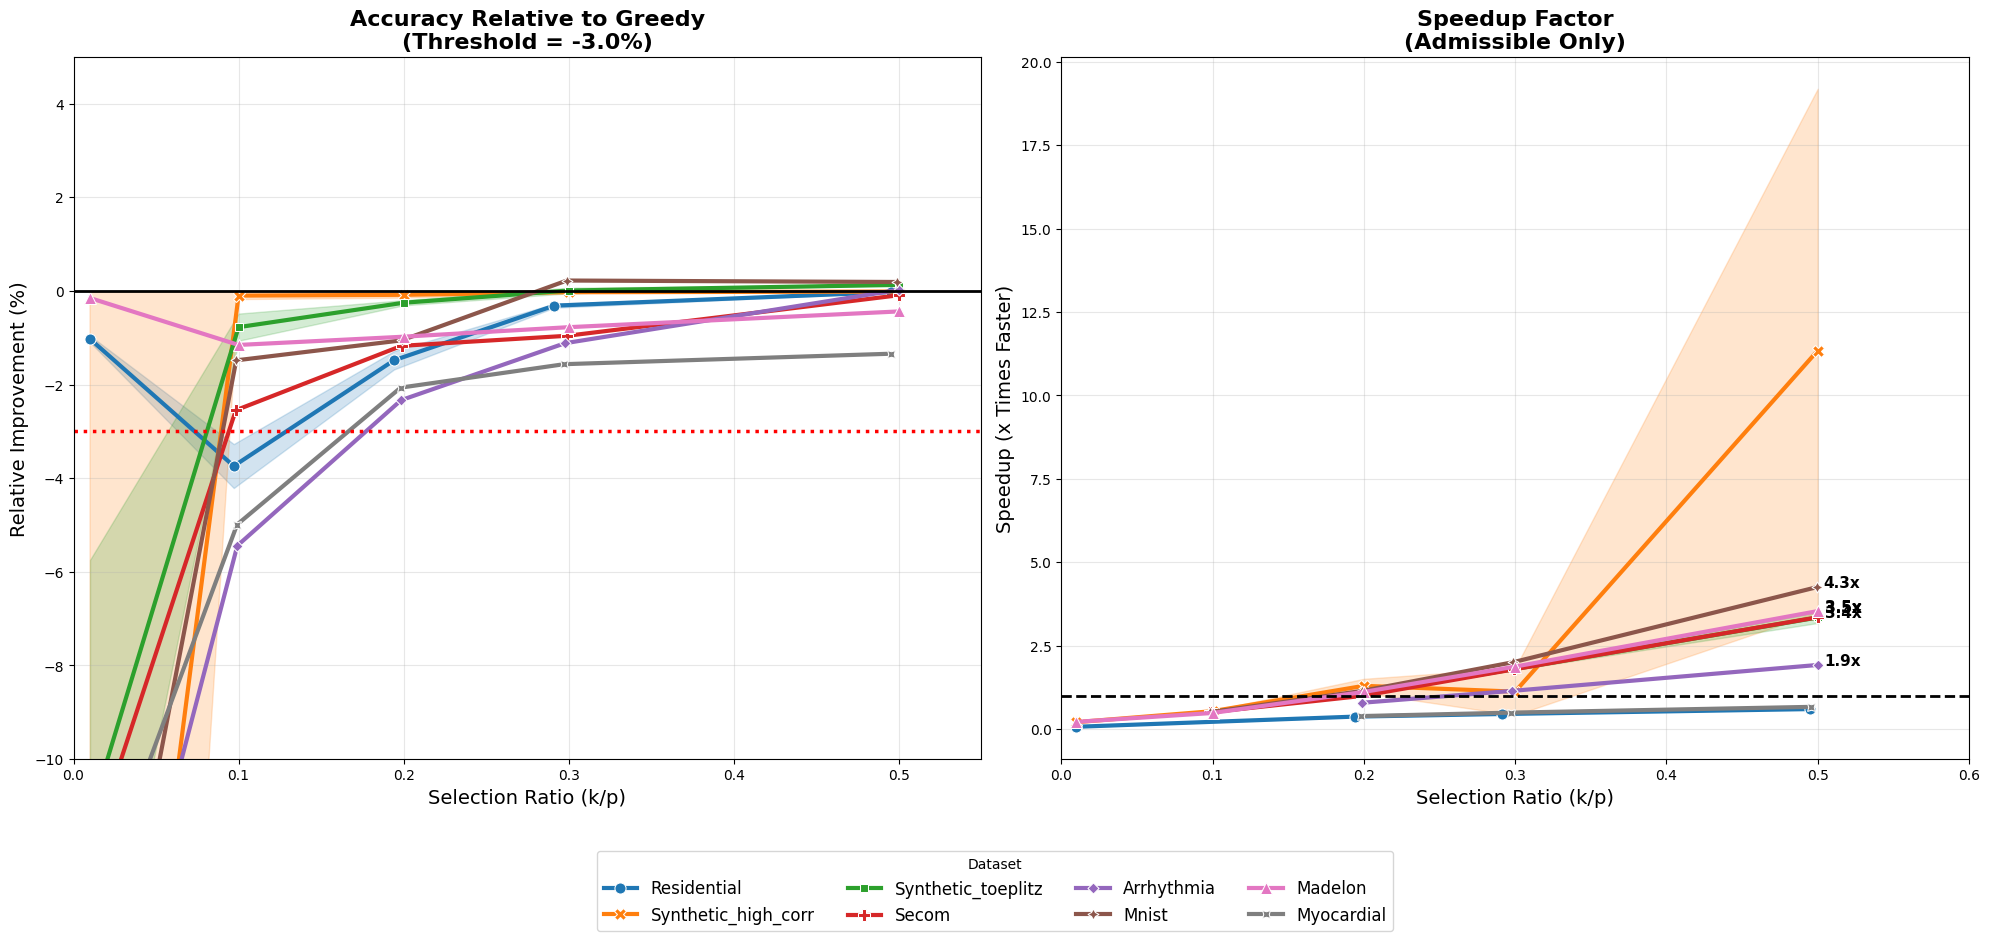

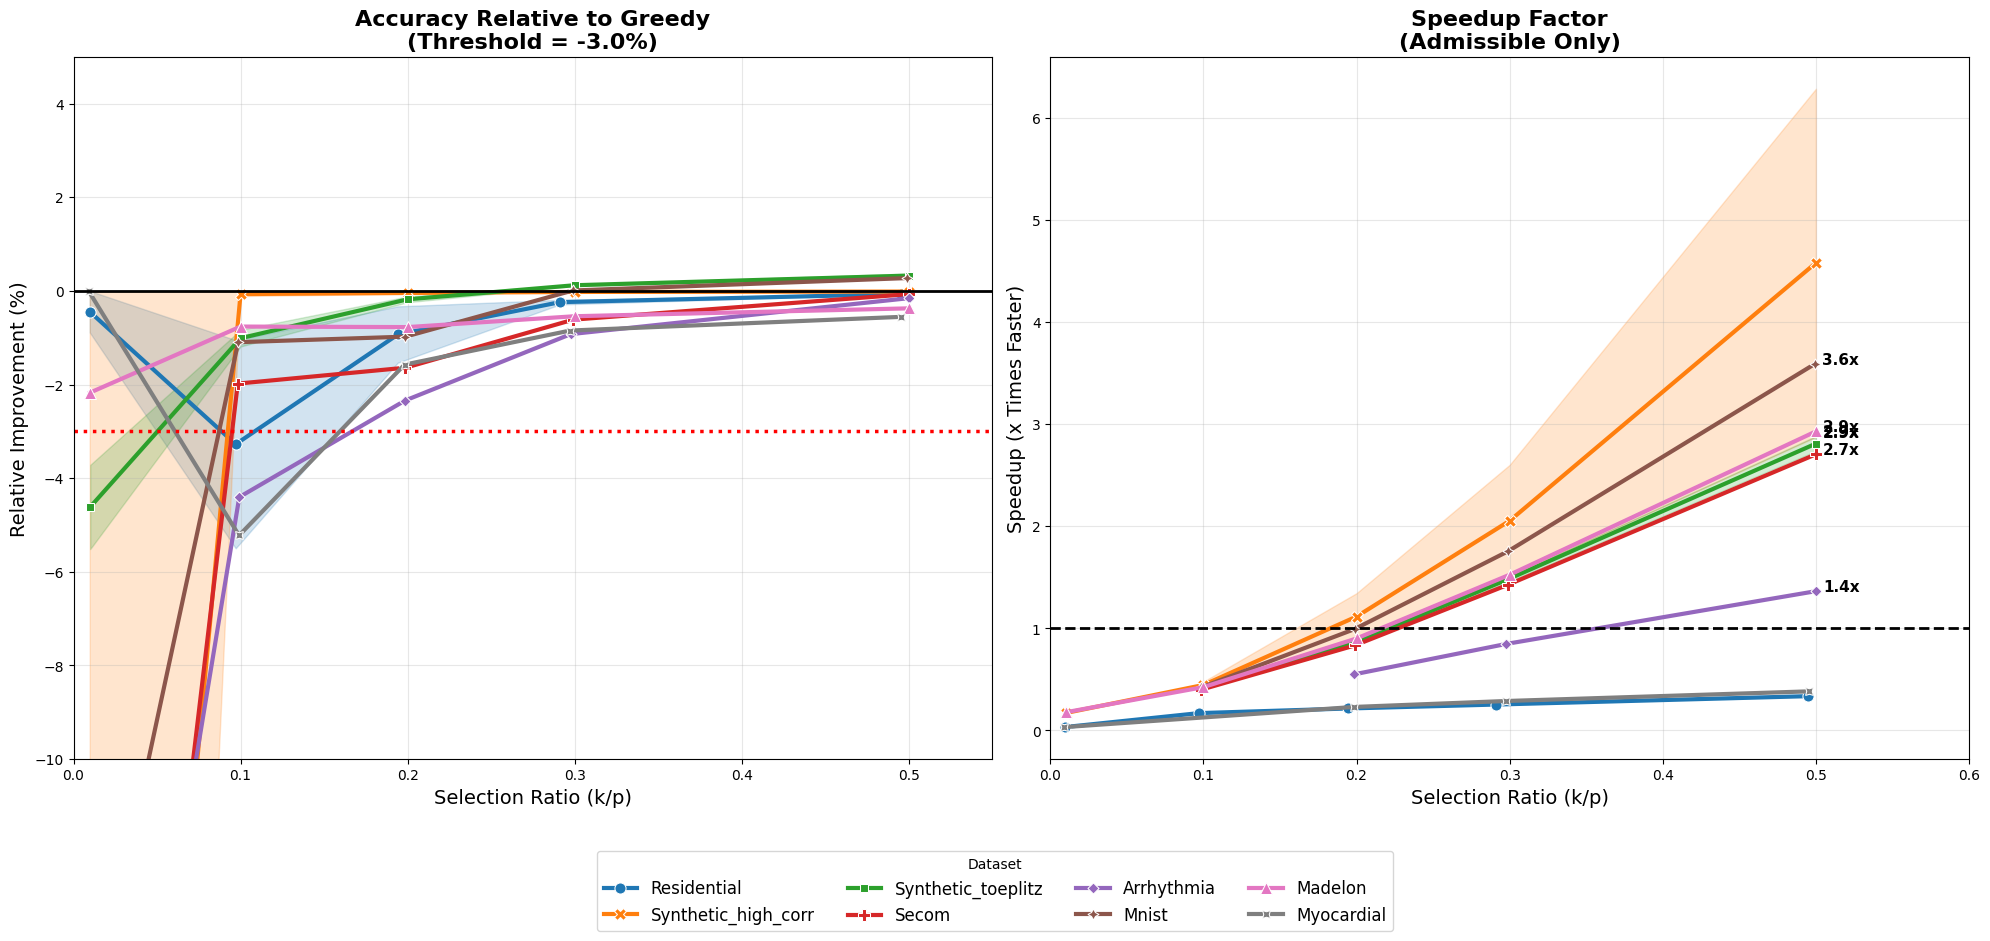

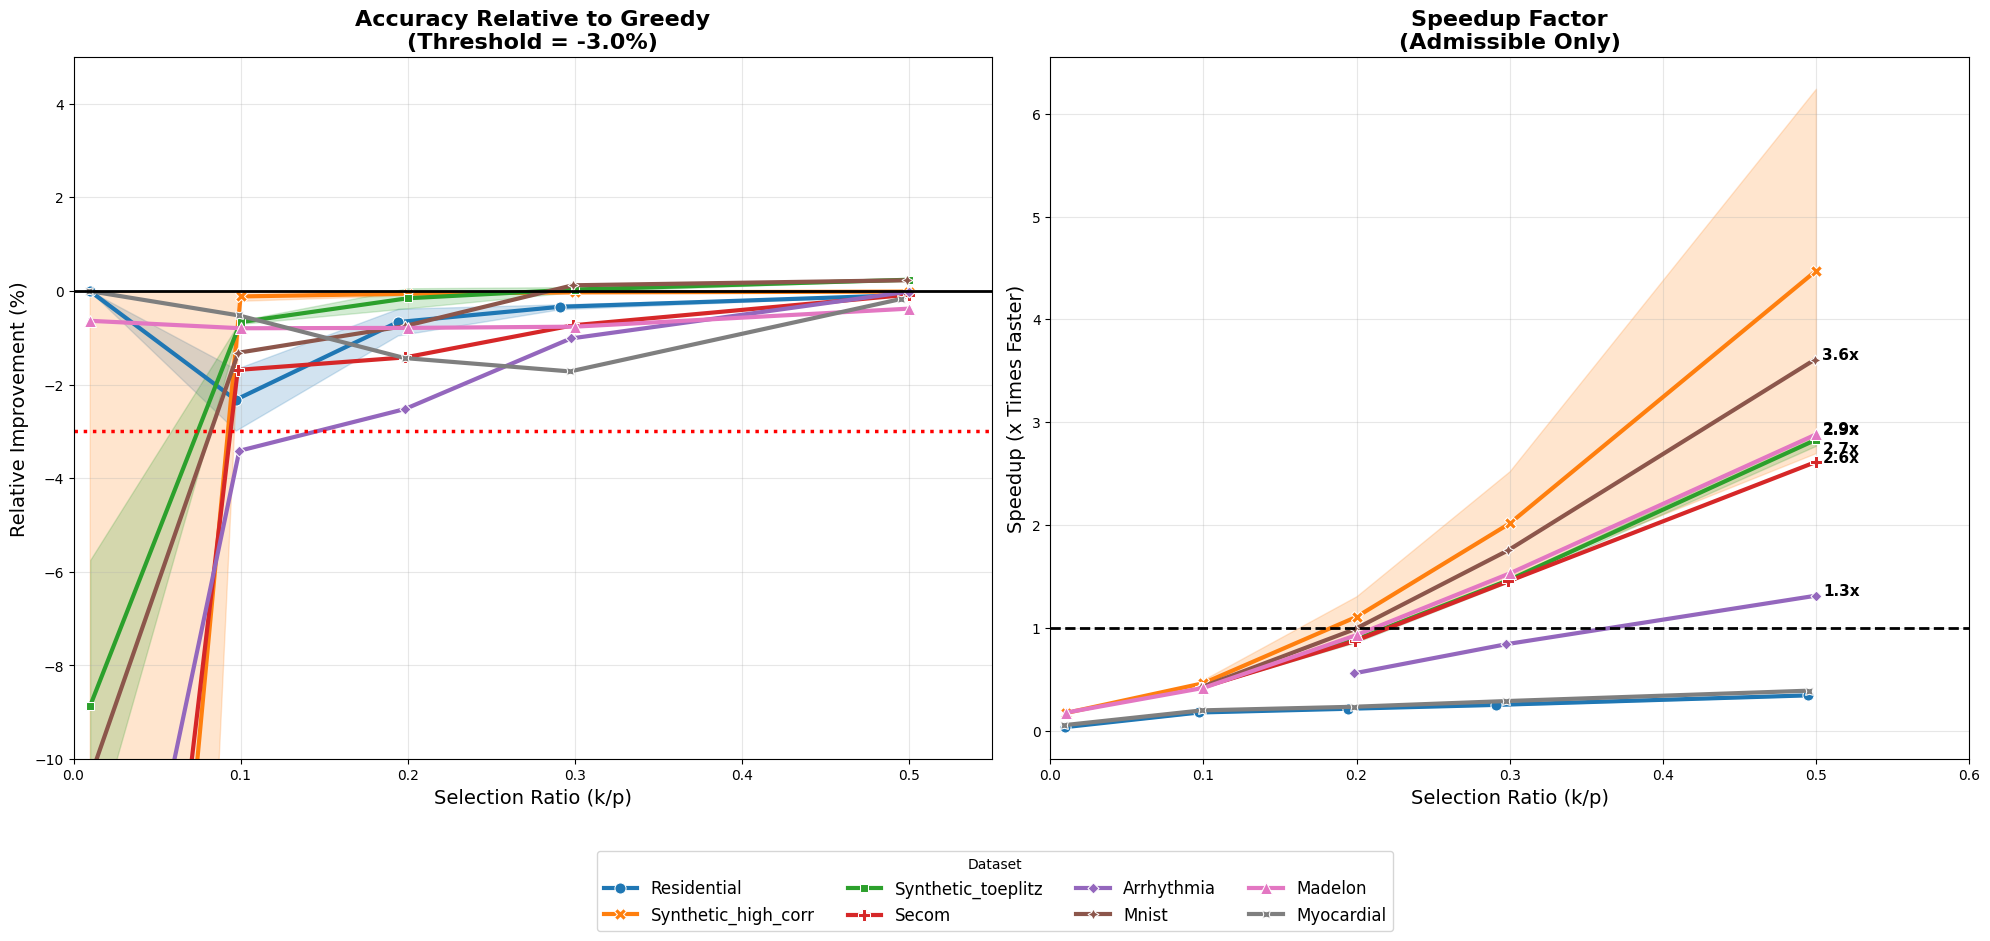

In [25]:
def plot_admissible_speedup_annotated(df, target_datasets, samples, fixed_alpha, tolerance_threshold=-3.0):
    # 1. Filter Data
    df_plot = df[
        (df["dataset"].str.lower().isin(target_datasets)) & 
        (df["samples"] == samples) & 
        (df["alpha"] == fixed_alpha)
    ].copy()

    if df_plot.empty:
        return

    # 2. Metrics
    df_plot["k_ratio"] = df_plot["k"] / df_plot["p"]
    df_plot["rel_imp"] = df_plot.apply(
        lambda x: ((x["fw_obj"] - x["greedy_obj"]) / x["greedy_obj"] * 100) 
        if x["greedy_obj"] != 0 else 0, axis=1
    )
    df_plot["valid_speedup"] = df_plot.apply(
        lambda x: x["speedup_x"] if x["rel_imp"] >= tolerance_threshold else np.nan, 
        axis=1
    )

    # 3. Setup Plot
    fig, axes = plt.subplots(1, 2, figsize=(20, 9))
    
    # --- PANEL 1: ACCURACY ---
    sns.lineplot(
        data=df_plot, x="k_ratio", y="rel_imp", 
        hue="dataset", style="dataset", 
        markers=True, dashes=False, linewidth=3, markersize=8,
        ax=axes[0], legend=False
    )
    
    axes[0].axhline(0, color='black', linestyle='-', linewidth=2)
    axes[0].axhline(tolerance_threshold, color='red', linestyle=':', linewidth=2.5)
    axes[0].set_title(f"Accuracy Relative to Greedy\n(Threshold = {tolerance_threshold}%)", fontsize=16, fontweight='bold')
    axes[0].set_ylabel("Relative Improvement (%)", fontsize=14)
    axes[0].set_xlabel("Selection Ratio (k/p)", fontsize=14)
    axes[0].set_ylim(-10, 5) 
    axes[0].set_xlim(0, 0.55)
    axes[0].grid(True, alpha=0.3)

    # --- PANEL 2: SPEEDUP ---
    sns.lineplot(
        data=df_plot, x="k_ratio", y="valid_speedup", 
        hue="dataset", style="dataset", 
        markers=True, dashes=False, linewidth=3, markersize=8,
        ax=axes[1], legend=True
    )
    
    axes[1].axhline(1.0, color='black', linestyle='--', linewidth=2)
    axes[1].set_title(f"Speedup Factor\n(Admissible Only)", fontsize=16, fontweight='bold')
    axes[1].set_ylabel("Speedup (x Times Faster)", fontsize=14)
    axes[1].set_xlabel("Selection Ratio (k/p)", fontsize=14)
    axes[1].set_xlim(0, 0.60) # Extend limit slightly to make room for text
    axes[1].grid(True, alpha=0.3)

    # =========================================================
    # NEW: AUTOMATIC ANNOTATION LOGIC
    # =========================================================
    # We only annotate the LAST point of each line to show final speedup
    for dataset in df_plot["dataset"].unique():
        # Get data for this specific line
        subset = df_plot[df_plot["dataset"] == dataset]
        
        # Get the point with the highest k_ratio (the right-most point)
        # We only care if it has a valid speedup (not NaN)
        valid_subset = subset.dropna(subset=["valid_speedup"])
        
        if not valid_subset.empty:
            # Pick the last point
            last_point = valid_subset.sort_values("k_ratio").iloc[-1]
            
            x_val = last_point["k_ratio"]
            y_val = last_point["valid_speedup"]
            
            # Only annotate if speedup is significant (> 1.5x) or interesting
            if y_val > 1.2:
                axes[1].annotate(
                    f"{y_val:.1f}x", 
                    (x_val, y_val), 
                    xytext=(5, 0), # Shift text slightly right
                    textcoords='offset points',
                    fontsize=11, 
                    fontweight='bold',
                    color='black'
                )

    # --- SHARED LEGEND ---
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].get_legend().remove()
    fig.legend(
        handles, labels, 
        loc='lower center', 
        bbox_to_anchor=(0.5, -0.05),
        ncol=4, fontsize=12, frameon=True, title="Dataset"
    )

    plt.tight_layout(rect=[0, 0.08, 1, 1])
    
    save_path = PROJECT_ROOT / "logs" / "plots" / "compare_k" / f"line_alpha{fixed_alpha}_m{samples}_annotated.pdf"
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches="tight") 
    plt.show()
# Run it
# targets = ["synthetic_high_corr", "synthetic_toeplitz", "mnist", "residential", "secom"] 
targets = ["synthetic_high_corr", "synthetic_toeplitz", "mnist", "residential", "secom", "myocardial", "arrhythmia", "madelon"] 
# Try with a tolerance of -3% (or -5% if you want to be lenient)
for s in [20, 50]:
    for a in [0.1, 0.2]:
        plot_admissible_speedup_annotated(df, targets, samples=s, fixed_alpha=a, tolerance_threshold=-3.0)